# Learning To Rank

* [From RankNet to LambdaRank to LambdaMART: An Overview](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)
* [Learning to Rank Explained (with Code)](https://mlexplained.com/2019/05/27/learning-to-rank-explained-with-code/)
* [Learning to Rank with Nonsmooth Cost Functions](https://pdfs.semanticscholar.org/fc9a/e09f9ced555558fdf1e997c0a5411fb51f15.pdf)

Dataset:
* [LETOR: Learning to Rank for Information Retrieval](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-4-0) (MQ2008)

In [1]:
%matplotlib inline

import sys
import io
import urllib
import zipfile
from pathlib import Path
from typing import Tuple, Dict, Callable

import tqdm
import numpy as np
import pandas as pd

import torch
from torch import nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.datasets import load_svmlight_file

"The larger the relevance label, the more relevant the query-document pair"

In [2]:
def get_data(file_path: Path):
    x, y, q = load_svmlight_file(
        str(file_path.resolve()), query_id=True, 
        n_features=46, zero_based=False, dtype=np.float32)
    y = y.astype(np.float32)
    unique_q = np.unique(q)
    q_map = {qid: np.argwhere(qid==q).flatten()
             for qid in unique_q}
    q_map_nonzero = {
        k:v for k, v in q_map.items() if any(y[v]>0)}
    return x.todense(), y, q, q_map, q_map_nonzero


# filepath = Path('/home/peter/Downloads/datasets/MSLR-WEB10K/Fold1/vali.txt')
data_dir = Path('/home/peter/Downloads/datasets/MQ2008/Fold1/')

x_train, y_train, q_train, q_train_map, q_train_map_nonzero = get_data(data_dir / 'train.txt')
print('Training Set:')
print('x_train: ', x_train.dtype, x_train.shape)
print('y_train: ', y_train.dtype, y_train.shape)
print('q_train: ', q_train.dtype, q_train.shape)
print('q_train_map: ', len(q_train_map))
print('q_train_map_nonzero: ', len(q_train_map_nonzero))

x_val, y_val, q_val, q_val_map, q_val_map_nonzero = get_data(data_dir / 'vali.txt')
print('\nValidation Set:')
print('x_val: ', x_val.dtype, x_val.shape)
print('y_val: ', y_val.dtype, y_val.shape)
print('q_val: ', q_val.dtype, q_val.shape)
print('q_val_map: ', len(q_val_map))
print('q_val_map_nonzero: ', len(q_val_map_nonzero))

x_test, y_test, q_test, q_test_map, q_test_map_nonzero = get_data(data_dir / 'test.txt')
print('\nTest Set:')
print('x_test: ', x_test.dtype, x_test.shape)
print('y_test: ', y_test.dtype, y_test.shape)
print('q_test: ', q_test.dtype, q_test.shape)
print('q_test_map: ', len(q_test_map))
print('q_test_map_nonzero: ', len(q_test_map_nonzero))

Training Set:
x_train:  float32 (9630, 46)
y_train:  float32 (9630,)
q_train:  int64 (9630,)
q_train_map:  471
q_train_map_nonzero:  339

Validation Set:
x_val:  float32 (2707, 46)
y_val:  float32 (2707,)
q_val:  int64 (2707,)
q_val_map:  157
q_val_map_nonzero:  120

Test Set:
x_test:  float32 (2874, 46)
y_test:  float32 (2874,)
q_test:  int64 (2874,)
q_test_map:  156
q_test_map_nonzero:  105


## Ranking quality measure

We will use [normalised discounted cumulative gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) (NDCG) as a measure of ranking quality.

This measure is based upon the discounted cumulative gain (DCG) at top-$k$ which is defined as:

$$
\text{DCG}_{k} = \sum_{i=1}^{k} \frac{2^{R_{i}} - 1}{\log_{2}(i+1)}
$$

Where $k$ is the top $k$ ranked elements and $R_i$ is the relevance score at position $i$. (Please note that in some other texts $2^{R_{i}} - 1$ is sometimes replaced with just $R_{i}$).

Then the ideal discounted cumulative gain (IDCG) is the DCG computed from a perfect ranking based on the true relevance scores $R_i$.

We can use both to compute the NDCG as:

$$
\text{NDCG}_{k} = \frac{\text{DCG}_{k}}{\text{IDCG}_{k}}
$$

In [3]:
def dcg(rels: np.ndarray, topk: int):
    weighting = np.log2(np.arange(1, topk+1) + 1)
    weighted_rels = (2**rels[:topk] - 1) / weighting
    return weighted_rels.sum()


def idcg(rels: np.ndarray, topk: int):
    ideal_rels = np.sort(rels)[::-1]
    return dcg(ideal_rels, topk=topk)


def ndcg(rels: np.ndarray, topk: int):
    topk = min(topk, rels.shape[0])
    d = dcg(rels, topk=topk)
    i = idcg(rels, topk=topk)
    if i == 0:
        return 1.  # No ideal ranking defined
    return d / i


# Test
assert np.isclose(dcg(np.array([1, 0]), topk=2), 1.)
assert np.isclose(dcg(np.array([0, 0, 1]), topk=2), 0.)
assert np.isclose(dcg(np.array([0, 1]), topk=2), 1/1.585, atol=1e-3)
assert np.isclose(idcg(np.array([0, 1]), topk=2), 1.)
assert np.isclose(
    idcg(np.array([0, 1, 0, 2, 1]), topk=4), 
    dcg(np.array([2, 1, 1, 0, 0]), topk=4))
assert np.isclose(ndcg(np.array([1, 0]), topk=2), 1.0)
assert np.isclose(ndcg(np.array([0, 1]), topk=2), 1/1.585, atol=1e-3)
docs_test_rels_all = np.array([3, 3, 3, 2, 2, 2, 1, 0])
docs_test_rank = np.array([1, 3, 0, 7, 6, 5, 2, 4])
docs_test_rels_rank = docs_test_rels_all[docs_test_rank]
assert np.isclose(dcg(docs_test_rels_rank, topk=6), 13.8481, atol=1e-3)
assert np.isclose(idcg(docs_test_rels_rank, topk=6), 18.437, atol=1e-3)
assert np.isclose(ndcg(docs_test_rels_rank, topk=6), 0.751, atol=1e-3)
assert np.isclose(ndcg(docs_test_rels_all, topk=6), 1.0, atol=1e-3)

In [4]:
def evalute_scores(
        scores: np.ndarray,
        q_relevances: np.ndarray,
        topk: int):
    scores_argsort = np.argsort(scores, axis=0)[::-1]
    q_relevances_sort_by_score = q_relevances[scores_argsort]
    ndcg_scores = ndcg(q_relevances_sort_by_score, topk=topk)
    return ndcg_scores


ndcg_test = evalute_scores(
    scores=np.asarray([1., 0.]),
    q_relevances=np.asarray([1., 0.]),
    topk=2)
assert np.isclose(ndcg_test, 1.0)
ndcg_test = evalute_scores(
    scores=np.asarray([1., 0.]),
    q_relevances=np.asarray([0., 1.]),
    topk=2)
assert np.isclose(ndcg_test, 1/1.585, atol=1e-3)
ndcg_test = evalute_scores(
    scores=np.asarray([2., 1., 0.]),
    q_relevances=np.asarray([0., 0., 1.]),
    topk=2)
assert np.isclose(ndcg_test, 0.0)

In [5]:
def evaluate_model(
        q_map: Dict[int, np.ndarray],
        all_features: np.ndarray,
        all_relevances: np.ndarray,
        model: torch.nn.Module,
        topk: int):
    ndcg_sum = 0.
    count = 0.
    for qid, _ in q_map.items():
        # Get input
        idxs = q_map[qid]
        q_relevances = all_relevances[idxs]
        q_features = torch.from_numpy(all_features[idxs, :])
        # Score
        with torch.no_grad():
            scores = model(q_features).squeeze()
        ndcg_scores = evalute_scores(
            scores=np.asarray(scores),
            q_relevances=q_relevances,
            topk=topk)
        ndcg_sum += ndcg_scores
        count += 1
    return ndcg_sum / count


ndcg_test_all = evaluate_model(
    q_map=q_test_map_nonzero,
    all_features=x_test,
    all_relevances=y_test,
    model=nn.Linear(46, 1),
    topk=5)
assert 0 <= ndcg_test_all <= 1

## Ranking model

### RankNet

RankNet is a pairwise model. For every ordered pair of documents $[U_i, U_j]$ passed as input into RankNet it will output the probability $P_{ij} = P(U_i > U_j)$ that $U_i$ is more relevant than $U_j$. 

RankNet outputs the probability by first mapping input feature vectors of the documents $U_k$ $\mathbf{x_k}$ to a number $s_k = f_{\theta}(\mathbf{x_k})$ where $f_{\theta}$ is a function parameterized by $\theta$. It then maps the difference between these scores $s_i - s_j$ to a value between $0$ and $1$ with the help of the logistic sigmoid function.

$$
P_{ij} = P(U_i > U_j) = \frac{1}{1 + \exp(s_j - s_i)}
$$



#### Training RankNet

RankNet learns $P_{ij}$ by training on every pair of documents $U_i > U_j$ where $U_i$ is more relevant than $U_j$. In this case the target probability should be $1 = P_{ij}$ and the negative log-likelihood (cross entropy) can be used as a loss function:

$$
\mathcal{L}_{i,j} = - \log P_{i,j} = \log(1 + \exp(s_j - s_i))
$$

Where the total loss is defined as the sum $\mathcal{L} = \sum_{(i,j) \in D} \mathcal{L}_{i,j}$.

We can write out the gradients of this loss $\mathcal{L}$ with respect to the parameters $\theta$ as follows:

$$
\begin{align}
\frac{\partial \mathcal{L}_{i,j}}{\partial \theta} &= \frac{\partial \mathcal{L}_{i,j}}{\partial s_i}  \frac{\partial s_i}{\partial \theta} + \frac{\partial \mathcal{L}_{i,j}}{\partial s_j}  \frac{\partial s_j}{\partial \theta} \\
&= \frac{-\exp(s_j - s_i)}{1 + \exp(s_j - s_i)}  \frac{\partial s_i}{\partial \theta} + \frac{\exp(s_j - s_i)}{1 + \exp(s_j - s_i)}  \frac{\partial s_j}{\partial \theta} \\
&= \frac{-\exp(s_j - s_i)}{1 + \exp(s_j - s_i)} \left( \frac{\partial s_i}{\partial \theta} - \frac{\partial s_j}{\partial \theta} \right) \\
&= -\frac{1}{1 + \exp(s_i - s_j)} \left( \frac{\partial s_i}{\partial \theta} - \frac{\partial s_j}{\partial \theta} \right) \\
&= \lambda_{i,j} \left( \frac{\partial s_i}{\partial \theta} - \frac{\partial s_j}{\partial \theta} \right) \\
\end{align}
$$

With $ \lambda_{i,j} = -1 / (1 + \exp(s_i - s_j))$ a weighting factor that determines how much to update parameters $\theta$ during a gradient descent step.

The total update for the loss then becomes:

$$
\frac{\partial \mathcal{L}}{\partial \theta} = \sum_{(i,j) \in D} \frac{\partial \mathcal{L}_{i,j}}{\partial \theta} 
= \sum_{(i,j) \in D} \lambda_{i,j} \left( \frac{\partial s_i}{\partial \theta} - \frac{\partial s_j}{\partial \theta} \right)
= \sum_{(i,j) \in D} \left(\lambda_{i,j} \frac{\partial s_i}{\partial \theta} - \lambda_{i,j} \frac{\partial s_j}{\partial \theta} \right)
$$

This means we can compute a $\lambda_k$ for each document $U_k$ by iterating over all pairs $U_i > U_j$ and accumulating $\lambda_k$:

$$
\lambda_k = \sum_{(i,j) \in D}^{\forall k = i} \lambda_{i, j} - \sum_{(i,j) \in D}^{\forall k = j} \lambda_{i, j}
$$

We can then update the parameters $\theta$ from $\lambda_k$ and the scores $s_k$ by:

$$
\theta(t+1) = \theta(t) - \mu \lambda_k \frac{\partial s_k}{\partial \theta(t)}
$$


### LambdaRank

One major disadvantage of RankNet is that the loss is agnostic to the actual ranking of the items. The loss is the same for every pair of items regardless where in the ranking they occur with keeping their relative ordering. E.g. the loss between $i$ and $j$ is the same whether they are ranked in 3rd and 5th place or 2nd and 51st place.

This can be circumvented by weighting the gradient $\lambda_{i,j}$ for the pairwise loss, for example by NDCG:
$$
\lambda_{i,j} = \frac{-1}{1 + \exp(s_i - s_j)} \lvert \Delta_{\text{NDCG}} \rvert
$$

Where $\lvert \Delta_{\text{NDCG}} \rvert$ is obtained by the absolute change in the NDCG score by swapping the rank positions of $i$ and $j$.

This could also be rewritten as:

$$
\lambda_{i,j} = - \left( \frac{1}{1 + \exp(s_i - s_j)} \right) \left| \left( 2^{R_i} - 2^{R_j} \right) \left( \frac{1}{\log_2(1+i)} - \frac{1}{\log_2(1+j)} \right) \frac{1}{\text{IDCG}_k} \right|
$$

In [6]:
def ndcg_delta(q_idcg, ri, rj, i_sort, j_sort):
    rank_power_diff = 2**ri - 2**rj
    # Plus 2 because of zero-based indexing
    weight_diff = (1. / np.log2(2+i_sort)) - (1. / np.log2(2+j_sort))
    return abs(rank_power_diff * weight_diff * (1./ q_idcg))


assert np.isclose(
    ndcg_delta(1., ri=1, rj=0, i_sort=0, j_sort=1),
    abs(ndcg(np.array([1, 0]), 2) - ndcg(np.array([0, 1]), 2)))
assert np.isclose(
    ndcg_delta(1., ri=1, rj=0, i_sort=1, j_sort=0),
    abs(ndcg(np.array([0, 1]), 2) - ndcg(np.array([1, 0]), 2)))
assert np.isclose(
    ndcg_delta(idcg(np.array([1, 2, 0, 2]), 3), ri=2, rj=0, i_sort=1, j_sort=2),
    abs(ndcg(np.array([1, 2, 0, 2]), 3) - ndcg(np.array([1, 0, 2, 2]), 3)))

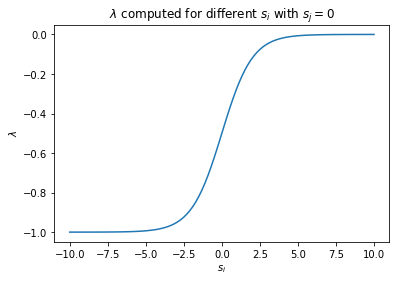

In [7]:
def lambda_basic(si, sj):
    return -1. / (1 + np.exp(si - sj))


plt.figure()
sis = np.linspace(-10, 10, 100)
plt.plot(sis, lambda_basic(sis, 0))
plt.xlabel('$s_i$')
plt.ylabel('$\lambda$')
plt.title('$\lambda$ computed for different $s_i$ with $s_j = 0$')
plt.show()

If $s_i$ is much larger than $s_j$ the score $\lambda$ becomes $0$, which is what we expect when $U_i > U_j$.

If $s_i$ is much smaller than $s_j$ the score $\lambda$ goes to $-1$.

In [8]:
def lambda_ndcg(q_idcg, si, sj, ri, rj, i_sort, j_sort):
    score_direction = lambda_basic(si, sj)
    ndcg_d = ndcg_delta(q_idcg, ri, rj, i_sort, j_sort)
    lmbd = score_direction * ndcg_d
    return lmbd


lmbd_good = lambda_ndcg(1, si=1., sj=0., ri=1, rj=0, i_sort=0, j_sort=1)
assert lmbd_good < 0.
lmbd_bad = lambda_ndcg(1, si=0., sj=1., ri=1, rj=0, i_sort=1, j_sort=0)
assert lmbd_bad < 0.
lmbd_neutral = lambda_ndcg(1, si=-1, sj=1, ri=0, rj=0, i_sort=1, j_sort=0)
assert lmbd_neutral == 0.

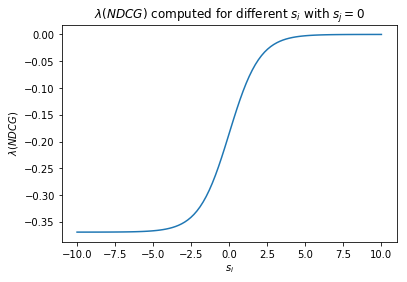

In [9]:
def plot_lambda():
    plt.figure()
    sis = np.linspace(-10, 10, 100)
    lmbds = [
        lambda_ndcg(
            1., si, 0, 1, 0, int(si>0), int(si<0)) for si in sis]
    plt.plot(sis, lmbds)
    plt.xlabel('$s_i$')
    plt.ylabel('$\lambda(NDCG)$')
    plt.title('$\lambda(NDCG)$ computed for different $s_i$ with $s_j = 0$')
    plt.show

plot_lambda()

In [10]:
def compute_lambdas(
        scores: np.ndarray,
        q_relevances: np.ndarray,
        topk: int):
    q_idcg = idcg(q_relevances, topk=topk)
    scores_argsort = np.argsort(scores, axis=0)[::-1]
    scores_sorted = scores[scores_argsort]
    assert all(scores_sorted[i] >= scores_sorted[i+1] for i in range(len(scores_sorted)-1))
    q_relevances_sort_by_score = q_relevances[scores_argsort]
    # Lambda follows same index as scores
    lambdas = np.zeros_like(scores)
    for i in range(scores_sorted.shape[0]):
        i_lmbd_idx = scores_argsort[i]
        assert scores[i_lmbd_idx] == scores_sorted[i]
        assert q_relevances[i_lmbd_idx] == q_relevances_sort_by_score[i]
        i_rel = q_relevances_sort_by_score[i]
        for j in range(scores_sorted.shape[0]):
            j_lmbd_idx = scores_argsort[j]
            j_rel = q_relevances_sort_by_score[j]
            if i_rel > j_rel:
                lmbd = lambda_ndcg(
                    q_idcg, 
                    scores_sorted[i],  scores_sorted[j], 
                    i_rel, j_rel, 
                    i, j)
                lambdas[i_lmbd_idx] += lmbd
                lambdas[j_lmbd_idx] -= lmbd
    return lambdas


assert np.allclose(
    compute_lambdas(np.array([1e9, -1e9]), np.array([1, 0]), 2),
    [0., 0.])
assert np.allclose(
    compute_lambdas(np.array([1e9, -1e9]), np.array([0, 1]), 2),
    [ndcg_delta(1., ri=1, rj=0, i_sort=0, j_sort=1), 
     -ndcg_delta(1., ri=1, rj=0, i_sort=0, j_sort=1)])
assert np.allclose(
    compute_lambdas(np.array([-1e9, 1e9]), np.array([1, 0]), 2),
    [-ndcg_delta(1., ri=1, rj=0, i_sort=0, j_sort=1), 
     ndcg_delta(1., ri=1, rj=0, i_sort=0, j_sort=1)])

In [11]:
model = nn.Linear(46, 1, bias=True)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
topk = 5
n_epoch = 10

q_train_ids = [k for k, _ in q_train_map_nonzero.items()]
print(f'#qID={len(q_train_ids)}')
total_iter = n_epoch * len(q_train_ids)

lambda_abs_batches = []
lambda_abs = []
ndcg_train = [(0, evaluate_model(q_train_map_nonzero, x_train, y_train, model, topk))]
ndcg_val = [(0, evaluate_model(q_val_map_nonzero, x_val, y_val, model, topk))]

iter_count = 0.
with tqdm.tqdm(total=total_iter, file=sys.stdout) as pbar:
    for epoch in range(n_epoch):
        qs = np.random.permutation(q_train_ids)
        lmbd_abs_size_total = 0.
        for batch_idx, qid in enumerate(qs):
            q_idxs = q_train_map_nonzero[qid]
            q_features = torch.from_numpy(x_train[q_idxs, :])
            optimizer.zero_grad()
            scores = model(q_features).squeeze()
            lambdas = compute_lambdas(
                scores=scores.detach().numpy(),
                q_relevances=y_train[q_idxs],
                topk=topk)
            scores.backward(torch.from_numpy(lambdas))
            optimizer.step()
            lmbd_abs_size = np.sum(np.absolute(lambdas)) / len(lambdas)
            lmbd_abs_size_total += lmbd_abs_size
            iter_count += 1
            lambda_abs_batches.append((iter_count, lmbd_abs_size))
            pbar.set_description(f'epoch: {epoch} | batch: {batch_idx}')
            pbar.update()
        lambda_abs.append(
            (iter_count, lmbd_abs_size_total / len(qs)))
        ndcg_train.append(
            (iter_count, evaluate_model(q_train_map_nonzero, x_train, y_train, model, topk)))
        ndcg_val.append(
            (iter_count, evaluate_model(q_val_map_nonzero, x_val, y_val, model, topk)))

#qID=339
epoch: 9 | batch: 338: 100%|██████████| 3390/3390 [00:27<00:00, 122.71it/s]


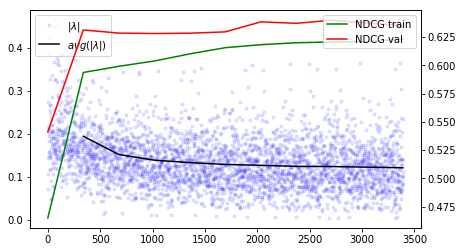

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))
# plt.plot(*zip(*ndcg_batches), 'b.', alpha=0.1, label='NDCG batch')
ax1.plot(*zip(*lambda_abs_batches), 'b.', alpha=0.1, label='$|\lambda|$')
ax1.plot(*zip(*lambda_abs), 'k-', label='$avg(|\lambda|)$')
ax2 = ax1.twinx() 
ax2.plot(*zip(*ndcg_train), 'g-', label='NDCG train')
ax2.plot(*zip(*ndcg_val), 'r-', label='NDCG val')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [14]:
ndcg_test = evaluate_model(q_test_map_nonzero, x_test, y_test, model, 6)
print('NDCG on relevant test data: ', ndcg_test)

ndcg_test = evaluate_model(q_test_map, x_test, y_test, model, 6)
print('NDCG on all test data: ', ndcg_test)

NDCG on relevant test data:  0.6751203941906415
NDCG on all test data:  0.7813310345513935
